In [24]:
# Load Data
import pandas as pd
data = pd.read_csv('isc_data.csv')

/tmp/ipykernel_5033/571714885.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('isc_data.csv')


In [25]:
# Getting treated cases
treated = data[data.ever_carer]
len(treated.pidp.unique())

593

In [28]:
treated

,Unnamed: 0,pidp,carer,wage_deflated,log_wage_h_deflated,wage_h_deflated,wave,date,employed,dvage,ever_carer,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,waves_caring
192,20,68068011,False,3142.124802,2.976169,19.612539,1,2009-01-01,employed,42,True,1,8,8,1,-7,5
193,8861,68068011,False,3137.759097,2.974779,19.585289,2,2010-01-01,employed,43,True,2,8,8,1,-6,5
194,20473,68068011,False,3103.573070,2.963824,19.371906,3,2011-01-01,employed,44,True,3,8,8,1,-5,5
195,32075,68068011,False,3035.902851,2.941779,18.949522,4,2012-01-01,employed,45,True,4,8,8,1,-4,5
196,43729,68068011,False,2937.195957,2.908725,18.333412,5,2013-01-01,employed,46,True,5,8,8,1,-3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77051,89964,1633102291,False,1722.488038,2.941435,18.943012,8,2018-01-01,employed,37,True,8,10,10,1,-2,3
77052,100304,1633102291,False,1638.576779,2.891493,18.020200,9,2019-02-01,employed,38,True,9,10,10,1,-1,3
77053,110069,1633102291,True,1569.713758,2.848559,17.262881,10,2020-01-01,employed,39,True,10,10,10,1,0,3
77054,119163,1633102291,True,1715.462031,2.937348,18.865743,11,2021-01-01,employed,40,True,11,10,10,1,1,3


In [27]:
# Get controls cases
controls = data[~data.ever_carer]
len(controls.pidp.unique())

9671

In [33]:
controls.log_wage_h_deflated.min()

-5.875634859195544

In [43]:
def get_control_clean(c_data, t_data):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        init = t_data[t_data.pidp == t_id].initial_wave.unique()[0]
        treat_time = t_data[t_data.pidp == t_id].wave_treat_real.unique()[0]
        last_wave = t_data[t_data.pidp == t_id].wave.max()
        length = (last_wave + 1) - init
        # HUGE PROBLEM HERE waves need to match exactly!!! do not use range!!!
        idx = c_data[(c_data.wave >= init) & (controls.wave <= last_wave)].groupby('pidp')['pidp'].transform('count') == length
        sub_sample = c_data[(c_data.wave >= init) & (c_data.wave <= last_wave)][idx].reset_index(drop=True)
        treat = t_data[t_data.pidp == t_id].pivot(index='wave', columns='pidp', values='wage_h_deflated')
        #treat.columns = ['treated']
        sub_sample = sub_sample.pivot(index='wave', columns='pidp', values='wage_h_deflated')
        sub_sample = pd.concat([treat, sub_sample], axis=1, join="inner")
        out['data'] = sub_sample
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [44]:
def is_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))
idx = []
for pidp in treated.pidp:
    idx.append(is_consecutive(treated[treated.pidp == pidp].wave))

In [45]:
len(treated[idx].pidp.unique())

414

In [46]:
samples = get_control_clean(controls, treated[idx])

In [49]:
from typing import List
from operator import add
from toolz import reduce, partial
import numpy as np
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from multiprocessing import Pool

def create_index(x):
    y = np.arange(len(x)) + 1
    return y - x

def create_relative_index(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]

def create_relative_MultiIndex(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]


# the expression to minimise, since \mu is 0, we are one looking for \omega/W
def argmin_w(W, Y_i, Y_0):
    return np.sqrt(np.sum((Y_0 - Y_i.dot(W))**2))


# a function wrapping the whole process
def get_w(Y_i, Y_0):
    w_start = [1/Y_i.shape[1]]*Y_i.shape[1]
    weights = minimize(partial(argmin_w, Y_i=Y_i, Y_0=Y_0),
                       np.array(w_start),
                       method='SLSQP',
                       constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), # constraint to sum to 1
                       bounds=[(0.0, 1.0)]*len(w_start),
                       )
    return weights.x

def sc(x):
    data = x['data'].copy()
    t_time = x['treat_time']
    data.sort_index(inplace=True)
    data.index = create_relative_index(data.index.tolist(), t_time)
    df_T0 = data.loc[:-1, :] # this needs to be revised
    Y_0 = df_T0.iloc[:, 0].values
    kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(df_T0.T, k=300, return_distance=False)[0, 1:]
    Y_i = df_T0.iloc[:, idx].values
    weights = get_w(Y_i, Y_0)
    synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
    treated = data.iloc[:, 0]
    diff = treated - synth
    std_diff = (diff - diff.mean())/ diff.std()
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff,
        'std_diff': std_diff
    }


def isc(data_objects: list) -> dict:
    synths = []
    treats = []
    diffs = []
    std_diffs = []
    with Pool() as p:
        out = p.map(sc, data_objects)
    for ele in out:
        synths.append(ele['synth'])
        treats.append(ele['treated'])
        diffs.append(ele['diff'])
        std_diffs.append(ele['std_diff'])
    return {'synths': synths,
            'treats': treats,
            'diffs': diffs,
            'std_diffs': std_diffs}


In [50]:
out = isc(samples)

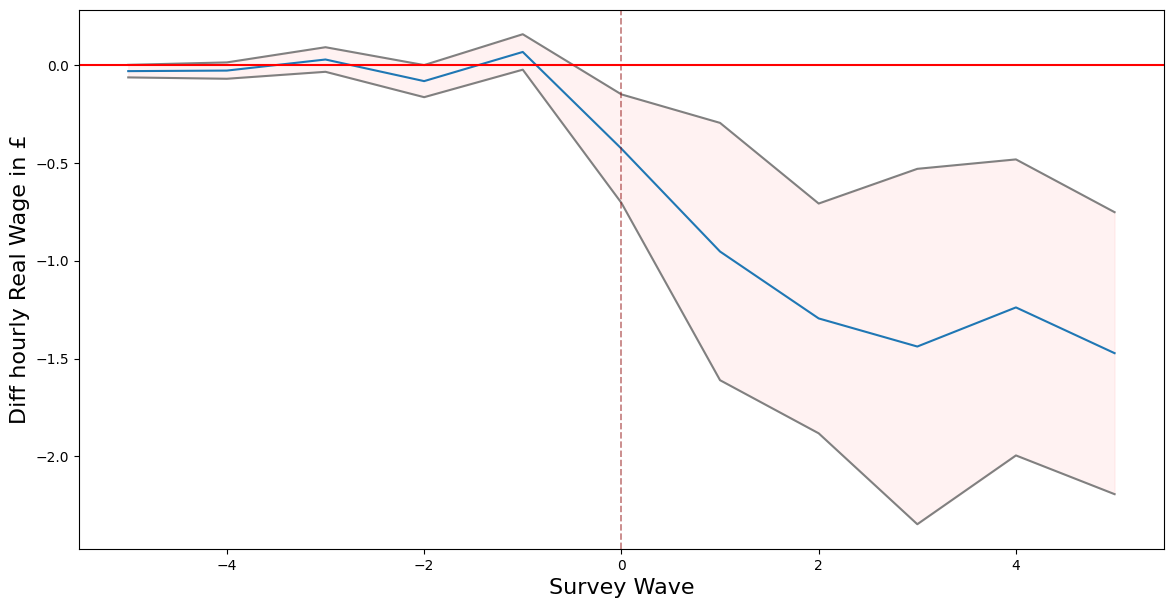

In [51]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

figure(figsize=(14, 7))
differences = pd.concat(out['diffs'], axis=1).sort_index()
differences.loc[-5:5].mean(axis=1).plot()
(differences.loc[-5:5].mean(axis=1) + (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt)))).plot(color='grey')
(differences.loc[-5:5].mean(axis=1) - (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt)))).plot(color='grey')
differences.count()
plt.axvline(x=0, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Survey Wave', fontsize=16)
plt.ylabel('Diff hourly Real Wage in £', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-')
plt.fill_between(x=differences.loc[-5:5].index,
                 y1=differences.loc[-5:5].mean(axis=1) + (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt))),
                 y2=differences.loc[-5:5].mean(axis=1) - (1.96*(differences.loc[-5:5].std(axis=1)/differences.loc[-5:5].count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.05)
plt.show()

In [48]:
def get_control_clean(c_data, t_data, features):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        init = t_data[t_data.pidp == t_id].initial_wave.unique()[0]
        treat_time = t_data[t_data.pidp == t_id].wave_treat_real.unique()[0]
        last_wave = t_data[t_data.pidp == t_id].wave.max()
        length = (last_wave + 1) - init
        # HUGE PROBLEM HERE waves need to match exactly!!! do not use range!!!
        idx = c_data[(c_data.wave >= init) & (controls.wave <= last_wave)].groupby('pidp')['pidp'].transform('count') == length
        sub_sample = c_data[(c_data.wave >= init) & (c_data.wave <= last_wave)][idx].reset_index(drop=True)
        treat = t_data[t_data.pidp == t_id].pivot(index='pidp', columns='wave')[features].T
        #treat.columns = ['treated']
        sub_sample = sub_sample.pivot(index='pidp', columns='wave')[features].T
        sub_sample = pd.concat([treat, sub_sample], axis=1, join="inner")
        out['data'] = sub_sample
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [49]:
new_samples = get_control_clean(controls, treated, ['wage_h_deflated', 'dvage'])

In [50]:
new_samples[0]['data']

pidp                 68068011   68035367   68042167   68044207   68045567    \
                wave                                                          
wage_h_deflated 1     19.612539  17.200761  21.022278  11.667351  17.544889   
                2     19.585289  18.059163  24.015987  10.403013  17.533167   
                3     19.371906  17.582557  25.205208  10.946832  16.771742   
                4     18.949522  18.790988  25.085248  10.669405  16.259468   
                5     18.333412  30.348789  23.594483  11.103215  12.632992   
                6     17.643905  32.315474  24.337381  10.634685  13.671931   
                7     17.546066  34.502454  24.384411  11.704135  18.457293   
                8     17.036082  32.812946  19.953831  12.049022   18.65082   
                9     17.240966  33.265448  23.955375  12.787756   19.15485   
                10     18.04848  32.510647  23.390415  11.532143  19.113669   
                11    16.535335  31.417872  23.377557  17.569695  18.741008   
                12    17.877472  32.738032  24.426964  12.452981  18.851066   
dvage           1            42         28         39         33         47   
                2            43         29         40         34         48   
                3            44         30         41         35         49   
                4            45         31         42         36         50   
                5            46         32         43         37         51   
                6            47         33         44         38         52   
                7            48         34         45         39         53   
                8            49         35         46         40         54   
                9            50         36         47         42         55   
                10           51         37         48         42         56   
                11           52         38         49         43         57   
                12           53         39         50         44         58   

pidp                 68060527   68105407   68163887   68167967   68167971    \
                wave                                                          
wage_h_deflated 1     20.181364  17.623234  15.955891   8.656346   8.149149   
                2     21.923473  16.192231  17.127955   9.902604   10.64578   
                3     24.606865   6.268459  15.305887   8.507252  12.189879   
                4     19.164899  15.768432  13.017326  10.435556   8.600733   
                5     20.726002   18.15833  16.516783   9.474744  10.932397   
                6     22.044729  14.565268   8.739161   9.044606  11.144234   
                7     19.603667  13.332777   6.718213   9.339359  11.395556   
                8     22.018349  17.087703  13.902243  10.734583    7.82091   
                9     21.566421  21.588024  14.404109  10.855318  10.298635   
                10    21.420884  18.311698  11.305467  13.956978  10.632626   
                11    22.208679  16.435968  33.917433  10.412654   13.32342   
                12    20.116323  18.607599  27.889296   10.92029   8.179164   
dvage           1            35         42         24         31         31   
                2            36         43         25         32         32   
                3            37         44         26         33         33   
                4            38         45         27         34         34   
                5            39         46         28         35         35   
                6            40         47         29         36         36   
                7            41         48         30         37         37   
                8            42         49         31         38         38   
                9            43         50         32         39         39   
                10           44         51         33         40         40   
                11           45         52       

In [73]:
example = new_samples[0]['data'].copy()
t_time = new_samples[0]['treat_time']
#example.sort_index(inplace=True)
example.index = create_relative_multiIndex(example.index.get_level_values('wave').tolist(), t_time)
#df_T0 = example.loc[:-1, :] # this needs to be revised
#df_T0
example

pidp,68068011,68035367,68042167,68044207,68045567,68060527,68105407,68163887,68167967,68167971,...,1633235567,1633244407,1633271607,1633314447,1633326687,1633326691,1633351851,1633780927,1634234487,1634453447
-7,19.612539,17.200761,21.022278,11.667351,17.544889,20.181364,17.623234,15.955891,8.656346,8.149149,...,10.482361,8.268015,12.458984,19.567054,25.157612,18.688512,32.380775,7.120079,22.736997,23.655916
-6,19.585289,18.059163,24.015987,10.403013,17.533167,21.923473,16.192231,17.127955,9.902604,10.64578,...,10.16136,7.816414,10.534443,19.718293,19.858157,14.225889,33.3397,8.086375,20.258479,54.063196
-5,19.371906,17.582557,25.205208,10.946832,16.771742,24.606865,6.268459,15.305887,8.507252,12.189879,...,10.070898,8.339517,11.054159,20.105362,23.7327,19.211874,28.482658,6.117593,20.726002,50.861889
-4,18.949522,18.790988,25.085248,10.669405,16.259468,19.164899,15.768432,13.017326,10.435556,8.600733,...,9.843117,9.438217,10.863763,19.659477,15.116386,10.534878,30.084266,6.149767,23.457464,46.263417
-3,18.333412,30.348789,23.594483,11.103215,12.632992,20.726002,18.15833,16.516783,9.474744,10.932397,...,8.102014,9.528285,10.809006,20.320425,19.815262,12.667291,30.823763,7.275292,24.250975,55.040194
-2,17.643905,32.315474,24.337381,10.634685,13.671931,22.044729,14.565268,8.739161,9.044606,11.144234,...,9.868837,9.089057,10.679815,19.995926,18.741727,12.866816,30.736429,10.590836,23.025611,49.439178
-1,17.546066,34.502454,24.384411,11.704135,18.457293,19.603667,13.332777,6.718213,9.339359,11.395556,...,10.730023,9.514755,10.491716,25.600012,18.473158,14.243723,29.593547,4.201173,22.686334,53.80152
0,17.036082,32.812946,19.953831,12.049022,18.65082,22.018349,17.087703,13.902243,10.734583,7.82091,...,10.662348,9.886147,10.94483,24.255884,19.069298,14.168335,29.228116,7.942618,23.941844,52.366813
1,17.240966,33.265448,23.955375,12.787756,19.15485,21.566421,21.588024,14.404109,10.855318,10.298635,...,10.241539,7.201337,10.240622,24.04947,18.604743,13.061179,20.128278,12.166985,22.525268,51.677776
2,18.04848,32.510647,23.390415,11.532143,19.113669,21.420884,18.311698,11.305467,13.956978,10.632626,...,11.277076,8.587528,10.663293,23.360833,16.810058,13.031783,25.89621,9.625749,25.370945,50.677561


In [ ]:
Y_0 = df_T0.iloc[:, 0].values
kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
idx = kdt.query(df_T0.T, k=100, return_distance=False)[0, 1:]
Y_i = df_T0.iloc[:, idx].values
weights = get_w(Y_i, Y_0)
synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
treated = data.iloc[:, 0]

In [30]:
treated

,Unnamed: 0,pidp,carer,wage_deflated,wage_h_deflated,wave,date,employed,dvage,waves_caring,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,ever_carer
201,17,68068011,False,3142.124802,19.612539,1,2009-01-01,employed,42,5,1,8,8,1,-7,True
202,6813,68068011,False,3137.759097,19.585289,2,2010-01-01,employed,43,5,2,8,8,1,-6,True
203,15809,68068011,False,3103.573070,19.371906,3,2011-01-01,employed,44,5,3,8,8,1,-5,True
204,24841,68068011,False,3035.902851,18.949522,4,2012-01-01,employed,45,5,4,8,8,1,-4,True
205,33934,68068011,False,2937.195957,18.333412,5,2013-01-01,employed,46,5,5,8,8,1,-3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85993,70374,1633102291,False,1722.488038,18.943012,8,2018-01-01,employed,37,3,8,10,10,1,-2,True
85994,78582,1633102291,False,1638.576779,18.020200,9,2019-02-01,employed,38,3,9,10,10,1,-1,True
85995,86341,1633102291,True,1569.713758,17.262881,10,2020-01-01,employed,39,3,10,10,10,1,0,True
85996,93577,1633102291,True,1715.462031,18.865743,11,2021-01-01,employed,40,3,11,10,10,1,1,True


In [129]:
out = {}
init = 2
treat_time = 6
last_wave = 9
length = (last_wave + 1) - init
# HUGE PROBLEM HERE waves need to match exactly!!! do not use range!!!
idx = controls[(controls.wave >= init) & (controls.wave <= last_wave)].groupby('pidp')['pidp'].transform('count') == length
idx
sub_sample = controls[(controls.wave >= init) & (controls.wave <= last_wave)][idx].reset_index(drop=True)
t = treated[treated.pidp == 68068011].pivot(index='pidp', columns='wave')[['wage_h_deflated', 'dvage']].T
s = sub_sample.pivot(index='pidp', columns='wave')[['wage_h_deflated', 'dvage']].T
sub_sample = pd.concat([t, s], axis=1, join="inner").dropna(axis=1)

In [128]:
controls.pivot(index='pidp', columns='wave')[['wage_h_deflated', 'dvage']].T.loc[(slice(None), slice(2,9)), :].dropna(axis=1)

pidp                 68035367   68042167   68044207   68045567   68046927    \
                wave                                                          
wage_h_deflated 2     18.059163  24.015987  10.403013  17.533167   9.074767   
                3     17.582557  25.205208  10.946832  16.771742   9.859596   
                4     18.790988  25.085248  10.669405  16.259468   9.612679   
                5     30.348789  23.594483  11.103215  12.632992   9.519157   
                6     32.315474  24.337381  10.634685  13.671931  11.531376   
                7     34.502454  24.384411  11.704135  18.457293  10.591423   
                8     32.812946  19.953831  12.049022   18.65082  11.889509   
                9     33.265448  23.955375  12.787756   19.15485   11.97953   
dvage           2            29         40         34         48         37   
                3            30         41         35         49         38   
                4            31         42         36         50         39   
                5            32         43         37         51         40   
                6            33         44         38         52         41   
                7            34         45         39         53         42   
                8            35         46         40         54         43   
                9            36         47         42         55         44   

pidp                 68060527   68105407   68120371   68163887   68166607    \
                wave                                                          
wage_h_deflated 2     21.923473  16.192231  10.330712  17.127955  13.325207   
                3     24.606865   6.268459  13.671401  15.305887  14.815262   
                4     19.164899  15.768432   7.678013  13.017326  14.651976   
                5     20.726002   18.15833  16.356753  16.516783  13.942203   
                6     22.044729  14.565268  13.289995   8.739161   8.062558   
                7     19.603667  13.332777  11.521258   6.718213   6.935342   
                8     22.018349  17.087703  18.970884  13.902243    7.89145   
                9     21.566421  21.588024  11.206224  14.404109   9.233259   
dvage           2            36         43         59         25         54   
                3            37         44         60         26         55   
                4            38         45         61         27         57   
                5            39         46         62         28         57   
                6            40         47         63         29         59   
                7            41         48         64         30         60   
                8            42         49         65         31         61   
                9            43         50         66         32         62   

pidp                  ... 1633272971 1633314447 1633326687 1633326691  \
                wave  ...                                               
wage_h_deflated 2     ...  14.698238  19.718293  19.858157  14.225889   
                3     ...  19.727421  20.105362    23.7327  19.211874   
                4     ...  17.196432  19.659477  15.116386  10.534878   
                5     ...  19.505649  20.320425  19.815262  12.667291   
                6     ...  18.694338  19.995926  18.741727  12.866816   
                7     ...  18.933076  25.600012  18.473158  14.243723   
                8     ...  22.697482  24.255884  19.069298  14.168335   
                9     ...  22.793118   24.04947  18.604743  13.061179   
dvage           2     ...         31         28         45         45   
                3     ...         32         29         46         46   
                4     ...         33         30         47         48   
                5     ...         34         31         48         48   
                6     ...         35         32         49         49   
                7     ...         36         33         50 

In [130]:
sub_sample

pidp                 68068011   68035367   68042167   68044207   68045567    \
                wave                                                          
wage_h_deflated 2     19.585289  18.059163  24.015987  10.403013  17.533167   
                3     19.371906  17.582557  25.205208  10.946832  16.771742   
                4     18.949522  18.790988  25.085248  10.669405  16.259468   
                5     18.333412  30.348789  23.594483  11.103215  12.632992   
                6     17.643905  32.315474  24.337381  10.634685  13.671931   
                7     17.546066  34.502454  24.384411  11.704135  18.457293   
                8     17.036082  32.812946  19.953831  12.049022   18.65082   
                9     17.240966  33.265448  23.955375  12.787756   19.15485   
dvage           2            43         29         40         34         48   
                3            44         30         41         35         49   
                4            45         31         42         36         50   
                5            46         32         43         37         51   
                6            47         33         44         38         52   
                7            48         34         45         39         53   
                8            49         35         46         40         54   
                9            50         36         47         42         55   

pidp                 68046927   68060527   68105407   68120371   68163887    \
                wave                                                          
wage_h_deflated 2      9.074767  21.923473  16.192231  10.330712  17.127955   
                3      9.859596  24.606865   6.268459  13.671401  15.305887   
                4      9.612679  19.164899  15.768432   7.678013  13.017326   
                5      9.519157  20.726002   18.15833  16.356753  16.516783   
                6     11.531376  22.044729  14.565268  13.289995   8.739161   
                7     10.591423  19.603667  13.332777  11.521258   6.718213   
                8     11.889509  22.018349  17.087703  18.970884  13.902243   
                9      11.97953  21.566421  21.588024  11.206224  14.404109   
dvage           2            37         36         43         59         25   
                3            38         37         44         60         26   
                4            39         38         45         61         27   
                5            40         39         46         62         28   
                6            41         40         47         63         29   
                7            42         41         48         64         30   
                8            43         42         49         65         31   
                9            44         43         50         66         32   

pidp                  ... 1633272971 1633314447 1633326687 1633326691  \
                wave  ...                                               
wage_h_deflated 2     ...  14.698238  19.718293  19.858157  14.225889   
                3     ...  19.727421  20.105362    23.7327  19.211874   
                4     ...  17.196432  19.659477  15.116386  10.534878   
                5     ...  19.505649  20.320425  19.815262  12.667291   
                6     ...  18.694338  19.995926  18.741727  12.866816   
                7     ...  18.933076  25.600012  18.473158  14.243723   
                8     ...  22.697482  24.255884  19.069298  14.168335   
                9     ...  22.793118   24.04947  18.604743  13.061179   
dvage           2     ...         31         28         45         45   
                3     ...         32         29         46         46   
                4     ...         33         30         47         48   
                5     ...         34         31         48         48   
                6     ...         35         32         49         49   
                7     ...         36         33         50 